# Neural Networks

Let's build a neural network for flowers classification...

![flowers](./imgs/jpg/image_0175.jpg)
![flowers](./imgs/jpg/image_0996.jpg)

**WARNING**: if your computer is too slow and not have enought power, maybe do not run the training cells... they are long to run on CPU...

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data.dataset import Dataset

from torchvision import transforms

import glob
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

%matplotlib inline

DEVICE = 'cpu'
BATCH_SIZE = 16
NB_CLASSES = 17
SIZE = 64

## Dataset

Making a dataset class to load the images for pytorch...

In [2]:
class FlowersDataset(Dataset):
    def __init__(self, size=SIZE, pct=.8, train=True, seed=1996):
        self.size = size
        #load images
        images_pathes = sorted(
            glob.glob("imgs/jpg/*.jpg"), 
            key=lambda s: int(s.split('/')[-1][:-4].split('_')[1])
        )
        #load labels
        labels = [i // 80 for i in range(len(images_pathes))]
        #shuffle the dataset
        data = list(zip(images_pathes, labels))
        random.Random(seed).shuffle(data)
        images_pathes, labels = list(zip(*data))
        #split the dataset and keep only the interesting part
        images_pathes = (
            images_pathes[:int(len(images_pathes) * pct)] 
            if train else 
            images_pathes[int(len(images_pathes) * pct):]
        )
        labels = (
            labels[:int(len(labels) * pct)] 
            if train else 
            labels[int(len(labels) * pct):]
        )
        self.images_pathes = images_pathes
        self.labels = labels
        #transormations
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            #transforms.RandomResizedCrop(self.size),
            transforms.RandomRotation(15),
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        #load image
        img = Image.open(self.images_pathes[index])
        img = img.resize((self.size, self.size), Image.BICUBIC)
        img = self.transform(img)
        #load label
        label = self.labels[index]
        return (img, label)

    def __len__(self):
        return len(self.labels)

In [3]:
flower_dataset_train = FlowersDataset(pct=.8, train=True)
flower_dataset_loader_train = torch.utils.data.DataLoader(
    dataset=flower_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

flower_dataset_test = FlowersDataset(pct=.8, train=False)
flower_dataset_loader_test = torch.utils.data.DataLoader(
    dataset=flower_dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Softmax Classifier

Let's try to classify those flowers a simple linear classifier...

In [4]:
class LinearClassifier(nn.Module):
    def __init__(self, input_size, nb_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_size, nb_classes),
            nn.Softmax(1)
        )
        
    def forward(self, x):
        return self.linear(x)
    

In [5]:
linear_model = LinearClassifier(SIZE * SIZE * 3, NB_CLASSES)
optimizer = optim.Adam(list(linear_model.parameters()))
loss_function = nn.CrossEntropyLoss()

print(linear_model)

LinearClassifier(
  (linear): Sequential(
    (0): Linear(in_features=12288, out_features=17, bias=True)
    (1): Softmax()
  )
)


2.9150963683626543	3.0500945299863815
2.913523058393108	3.050094500184059
2.9135231117704024	3.0500945448875427
2.913522844883933	3.0500945299863815
2.9135229551970068	3.0500945448875427
2.9135229374045757	3.0500945448875427
2.9135229729894383	3.0500945448875427
2.9135229374045757	3.0500945299863815
2.913522816416043	3.0500945448875427
2.9135227950651252	3.050094485282898
2.913522275526132	3.050094500184059
2.9128175279987394	3.0500946044921875
2.9135232149665033	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	3.0500946193933487
2.9135232185249897	

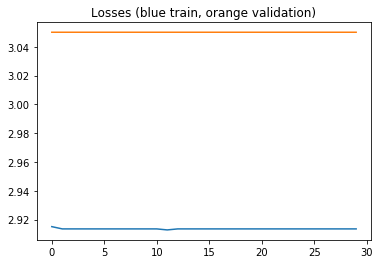

In [6]:
loss_history = []
loss_history_val = []
for epochs in range(30):
    #training
    mean_loss = 0.
    for i, (x, y) in enumerate(flower_dataset_loader_train):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, SIZE * SIZE * 3]).to(DEVICE)
        y = y.to(DEVICE)
        pred = linear_model(x.detach())
        loss = loss_function(pred, y.detach())
        mean_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mean_loss /= float(i)
    loss_history.append(float(mean_loss))
    print(mean_loss, end='\t')
    #validation
    mean_loss_val = 0.
    for i, (x, y) in enumerate(flower_dataset_loader_test):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, SIZE * SIZE * 3]).to(DEVICE)
        y = y.to(DEVICE)
        pred = linear_model(x.detach())
        loss = loss_function(pred, y.detach())
        mean_loss_val += loss.item()
    mean_loss_val /= float(i)
    loss_history_val.append(float(mean_loss_val))
    print(mean_loss_val)
        
plt.title("Losses (blue train, orange validation)")
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.show()


## ConvNet

Let's build a naïve convnet to compare if it could improve learning performances...

We will see later how to build powerfull NNs...

In [7]:
#ONLY TAKE 64x64 SIZE !
class ConvNet(nn.Module):
    def __init__(self, nb_channel_input, nb_classes):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(nb_channel_input, 8, 3, padding=1),
            nn.BatchNorm2d(8, affine=False),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.BatchNorm2d(8, affine=False),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.MaxPool2d((4, 4)),
        )
        self.fc = nn.Sequential(
            nn.Dropout(.25),
            nn.Linear(32 * 2 * 2, nb_classes),
            nn.Softmax(1)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [8]:
conv_net = ConvNet(3, NB_CLASSES)
optimizer = optim.Adam(list(conv_net.parameters()))
loss_function = nn.CrossEntropyLoss()

print(conv_net)

ConvNet(
  (conv): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))


2.8049994440221075	2.9308469742536545
2.7244899735521915	2.880208969116211
2.6401729832834273	2.841619312763214
2.591782388402455	2.752775192260742
2.5501906765041067	2.760784551501274
2.5237586320336187	2.773508608341217
2.5040747087393234	2.6780235171318054
2.4928497627599917	2.6684550046920776
2.4612817586357916	2.641323685646057
2.453399056818948	2.6141296923160553
2.434287864770462	2.567312866449356
2.3777425751757266	2.559334471821785
2.3775390617883025	2.5415319204330444
2.3745287923670526	2.542453721165657
2.3584882857194587	2.5197259932756424
2.364555003038093	2.51709520816803
2.3606735450118337	2.5196161568164825
2.35129295890011	2.511077955365181
2.360635896227253	2.5220667123794556
2.360207870825013	2.517266273498535
2.3519894204922576	2.5102550387382507
2.3462909549029907	2.5099435448646545
2.3461537823748233	2.521041214466095
2.346061176328517	2.4980659186840057
2.345093399731081	2.507884234189987
2.342045940569977	2.492511495947838
2.3393959572066123	2.514221742749214
2.

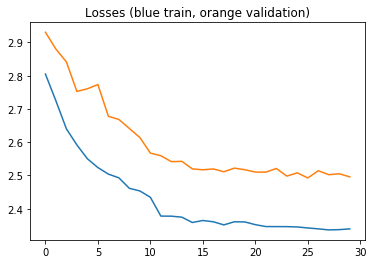

In [9]:
loss_history = []
loss_history_val = []
for epochs in range(30):
    #training
    conv_net.train()
    mean_loss = 0.
    for i, (x, y) in enumerate(flower_dataset_loader_train):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, 3, SIZE, SIZE]).to(DEVICE)
        y = y.to(DEVICE)
        pred = conv_net(x.detach())
        loss = loss_function(pred, y.detach())
        mean_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mean_loss /= float(i)
    loss_history.append(float(mean_loss))
    print(mean_loss, end='\t')
    #validation
    conv_net.eval()
    mean_loss_val = 0.
    for i, (x, y) in enumerate(flower_dataset_loader_test):
        if x.shape[0] != BATCH_SIZE:
            continue
        x = x.view([BATCH_SIZE, 3, SIZE, SIZE]).to(DEVICE)
        y = y.to(DEVICE)
        pred = conv_net(x.detach())
        loss = loss_function(pred, y.detach())
        mean_loss_val += loss.item()
    mean_loss_val /= float(i)
    loss_history_val.append(float(mean_loss_val))
    print(mean_loss_val)
    if epochs == 10:
        optimizer = optim.Adam(list(conv_net.parameters()), lr=0.0001)
        
plt.title("Losses (blue train, orange validation)")
plt.plot(loss_history)
plt.plot(loss_history_val)
plt.show()


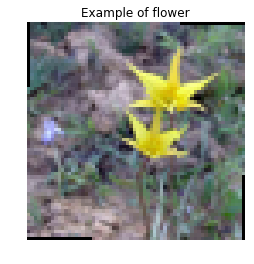

In [10]:
plt.title("Example of flower")
plt.axis("off")
plt.imshow(x[0].detach().numpy().transpose(1, 2, 0))
plt.show()

**Exercice**: _try to understand the code and create a simple 2 hidden layers fully connected network..._

(more on NN later...)